In [415]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sb
from datetime import datetime, timedelta
from scipy import spatial
import calplot

sb.set()

In [378]:
# open all data needed

# surveyed via census
# this data is from 2016-2021
# verified that geoids are uniqued already
acs_estimates = pd.read_csv('data/ACS-2021-5YR-B27010-tract/ACSDT5Y2021.B27010-Data.csv', skiprows=[0])
acs_estimates[['Geo Summary', 'Census GeoID']] = acs_estimates['Geography'].str.split(pat="US", expand=True)
acs_estimates['Census GeoID'] = acs_estimates['Census GeoID'].astype('int64')

# lat and long for each census tract
# renaming the columns for readability
census_tract_gaz = pd.read_csv('data/2022_Gaz_tracts_national.txt', sep='\t')
census_tract_gaz = census_tract_gaz.rename({'INTPTLAT': 'Latitude', 'INTPTLONG': 'Longitude'}, axis='columns')

# particulate matter pollution per lat and long collected by the epa
epa_pm_sensor = pd.read_csv('data/daily_88101_2020.csv')
epa_pm_sensor['Date Local'] = pd.to_datetime(epa_pm_sensor['Date Local'], format='%Y-%m-%d')

pd.set_option('display.max_columns', None)

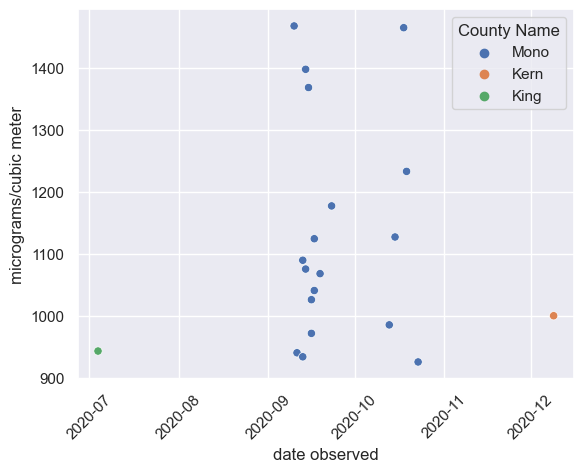

In [379]:
# Question 1
# As a sanity check, where and when were the highest PM2.5 pollution numbers observed
# in 2020? How would you interpret this measurement?
top_by_max = epa_pm_sensor.sort_values(by=['1st Max Value'], ascending=False).head(20)

#plotting
top_by_max.set_index(['Date Local'],inplace=True)
ax = sb.scatterplot(data=top_by_max, x=top_by_max.index, y=top_by_max["1st Max Value"], hue='County Name')
ax.set(xlabel="date observed", ylabel="micrograms/cubic meter")
ax.set_xlim(top_by_max.index.min() - timedelta(days=7), top_by_max.index.max() + timedelta(days=7))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.tick_params(axis="x", rotation=45)

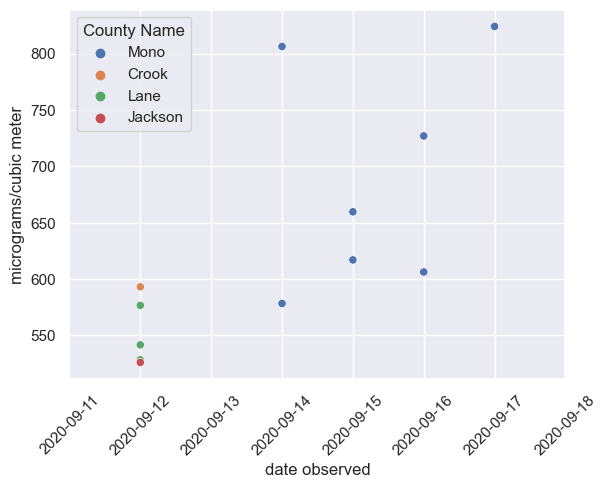

In [380]:
# Question 1 cont
top_by_avg = epa_pm_sensor.sort_values(by=['Arithmetic Mean'], ascending=False).head(20)

#plotting
top_by_avg.set_index(['Date Local'],inplace=True)
ax = sb.scatterplot(data=top_by_avg, x=top_by_avg.index, y=top_by_avg["Arithmetic Mean"], hue='County Name')
ax.set(xlabel="date observed", ylabel="micrograms/cubic meter")
ax.set_xlim(top_by_avg.index.min() - timedelta(days=1), top_by_avg.index.max() + timedelta(days=1))
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.tick_params(axis="x", rotation=45)

In [381]:
# Question 2
# Write a function that takes a Census Tract GEOID (corresponding to a single census
# tract) and plots out a daily time-series of the PM2.5 pollution in 2020, for the monitoring
# station closest to the tract’s centroid. Plot the time-series for five census tracts chosen at
# random from the Gazetteer.

# building a k-dimensional tree
# can query this to find the GEOID closest to the lat & long in the pm data
tree = spatial.KDTree(census_tract_gaz[['Latitude', 'Longitude']])

# creating a new column with the geoid assigned by closest point
# this takes a second to crunch through
epa_pm_sensor['Census GeoID'] = epa_pm_sensor.apply(lambda row: query_tree_for_geoid(row), axis=1)

def query_tree_for_geoid(row):
    lat = row['Latitude']
    long = row['Longitude']
    _, index = tree.query([(lat, long)])
    geoid = census_tract_gaz['GEOID'].values[index]
    return geoid[0]

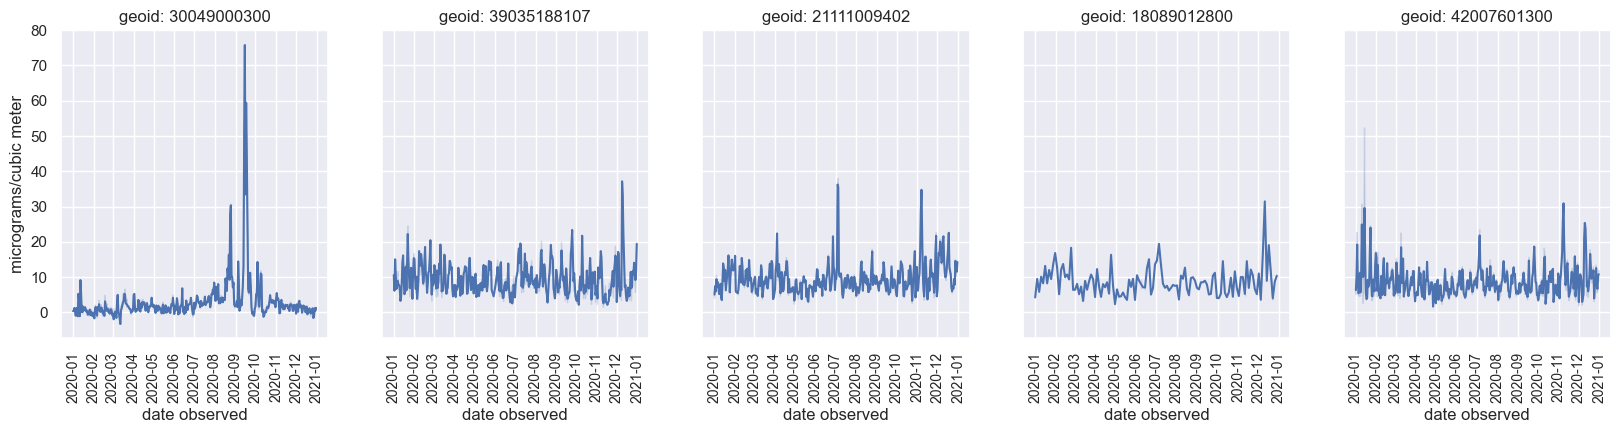

In [383]:
# Question 2 cont

def plot_pollution_for_geoid(i, geoid):
    current_plot = axes[i]
    
    geoid_readings = epa_pm_sensor[epa_pm_sensor['Census GeoID'] == int(geoid)]
    if geoid_readings.empty:
        print('no data found for geoid {}'.format(geoid))
        return
    geoid_readings.set_index(['Date Local'],inplace=True)
    sb.lineplot(ax=current_plot, data=geoid_readings, x=geoid_readings.index, y=geoid_readings["Arithmetic Mean"])
    current_plot.set_title('geoid: {}'.format(geoid))
    current_plot.set(xlabel="date observed", ylabel="micrograms/cubic meter")
    current_plot.xaxis.set_major_locator(mdates.MonthLocator())
    current_plot.tick_params(axis="x", labelrotation=90, labelsize=10)
    
# sampling from the gazeteer had really bad coverage
# so im sampling from the pm data to ensure we get some nice graphs
all_geoids = epa_pm_sensor['Census GeoID']
random_geoids = random.choices(all_geoids, k=5)

fig, axes = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(20,4))
for i, geoid in enumerate(random_geoids):
    plot_pollution_for_geoid(i, geoid)

In [384]:
# Question 3
# As a sanity check, what US Census tract(s) have the highest percentage of minors
# (people under the age of 19) with Medicaid/means-tested public coverage
# only?

minors_data = acs_estimates[['Census GeoID', 'Estimate!!Total:', 'Estimate!!Total:!!Under 19 years:', 'Estimate!!Total:!!Under 19 years:!!With one type of health insurance coverage:!!With Medicaid/means-tested public coverage only']]
minors_data = minors_data.rename({'Estimate!!Total:': 'Total Population', 'Estimate!!Total:!!Under 19 years:': 'Minor Population', 'Estimate!!Total:!!Under 19 years:!!With one type of health insurance coverage:!!With Medicaid/means-tested public coverage only': 'Minors with Medicaid'}, axis='columns')

minors_data['Percentage of Population'] = minors_data['Minors with Medicaid'] / minors_data['Total Population']
minors_data['Percentage of Minors'] = minors_data['Minors with Medicaid'] / minors_data['Minor Population']

# highest percentage of minors with medicaid (compared to general population)
top_by_population = minors_data.sort_values(by=['Percentage of Population'], ascending=False).head(20)
top_by_population[['Census GeoID', 'Total Population', 'Minors with Medicaid', 'Percentage of Population']]

,Census GeoID,Total Population,Minors with Medicaid,Percentage of Population
38895,26083980100,3,2,0.666667
32920,21221980100,17,11,0.647059
8053,6037980011,65,40,0.615385
68947,47037014800,1709,1047,0.612639
54082,36087012110,3364,1954,0.580856
54081,36087012109,3574,2049,0.573307
48599,34029715303,4332,2478,0.572022
54088,36087012116,3876,2204,0.568627
54064,36087011506,6063,3421,0.564242
48605,34029715502,8311,4679,0.562989


In [385]:
# Question 3 cont 

#highest percentage of minors with medicaid (compared to minor population)
top_by_minor_population = minors_data.sort_values(by=['Percentage of Minors'], ascending=False)
top_by_minor_population[['Census GeoID', 'Minor Population', 'Minors with Medicaid', 'Percentage of Minors']]


all_minors = top_by_minor_population[top_by_minor_population['Percentage of Minors'] == 1.0]
all_minors.shape

(240, 6)

In [397]:
def estimate_attacks(row):
    max_pm_reading = row['1st Max Value']
    if max_pm_reading < 10:
        return 0
    
    baseline_prob = 0.01
    baseline_increase_factor = 1.2
    
    row_increase_factor = baseline_increase_factor * (max_pm_reading / 10)
    
     
    chance_of_attack =  baseline_prob * row_increase_factor
    
    return row['Est Minor Population w Asthma'] * chance_of_attack

total estimated attacks in 2020 due to pollution: 73206.56290080001


(<Figure size 1250x170 with 2 Axes>,
 array([<AxesSubplot: ylabel='2020'>], dtype=object))

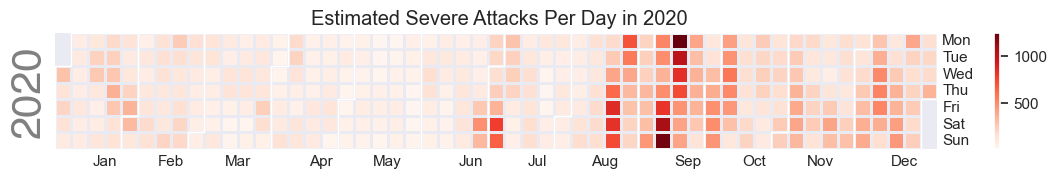

In [421]:
# Question 4
# PM2.5 is a cause of asthma attacks, especially in children. One study found the odds of
# a severe asthma attack rose the day after high PM2.5 levels. Its odds increased by a
# factor of 1.2 for every 10 Micrograms/cubic meter increase, over a baseline of 1% chance of
# hospitalization per day when the peak measurement was 10 the day prior.
# Assume that 7% of minors have asthma in every Census tract. Using the US Census
# data and PM2.5 pollution data, estimate how many additional asthma attacks were
# caused by PM2.5 pollution in 2020 compared to a baseline pollution level of less than 10 Micrograms/cubic meter

# establishing the estimated number of minors with asthma per tract
minors_per_tract = minors_data[['Census GeoID', 'Minor Population']].copy()
minors_per_tract['Est Minor Population w Asthma'] = minors_per_tract['Minor Population'] * 0.07

epa_small = epa_pm_sensor[['Sample Duration', 'Date Local', '1st Max Value', 'Census GeoID']].copy()
# limiting to one sample duration per day per location
epa_small = epa_small[epa_small['Sample Duration'] == '24-HR BLK AVG']

# merge the relevant census data with the relevant pm2.5 data
pm_levels_and_populations = pd.merge(epa_small, minors_per_tract, how='inner', on='Census GeoID')
pm_levels_and_populations['Est Next Day Attacks'] = pm_levels_and_populations.apply(lambda row: estimate_attacks(row), axis=1)

estimated_total_attacks = pm_levels_and_populations['Est Next Day Attacks'].sum()
print('total estimated attacks in 2020 due to pollution:', estimated_total_attacks)

pm_levels_and_populations.set_index('Date Local', inplace=True)
calplot.calplot(data = pm_levels_and_populations['Est Next Day Attacks'],how = 'sum', cmap = 'Reds', edgecolor=None, suptitle = "Estimated Severe Attacks Per Day in 2020")

In [ ]:
# Question 5
# Suppose that the odds of increased asthma attacks are actually not known precisely.
# Instead, we can summarize the evidence by saying that the rise in asthma attacks per 10 Micrograms/cubic meter
# is distributed, Exp[Normal[(0.1823, 0.0667)] which has a mean of 1.2.
# Assuming this is the only source of uncertainty, what should estimate the middle 95%
# range of additional asthma attacks caused by PM2.5 pollution in 2020 to be?
